In [1]:
%load_ext watermark


In [2]:
from IPython.display import display
import pandas as pd
import polars as pl
from scipy import stats as scipy_stats
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

from pylib.viz._size_fixation_areaplot import size_fixation_areaplot


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-09-30T07:52:41.560696+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1031-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

polars : 1.9.0
scipy  : 1.14.1
seaborn: 0.13.2
teeplot: 1.2.0
pandas : 2.2.3

Watermark: 2.4.3



In [4]:
teeplot_subdir = "cupy-5050-traits"
teeplot_subdir


'cupy-5050-traits'

In [5]:
data = [
    {
        "url": "https://osf.io/duam2/download",
        "population structure": "well-mixed"
    },
    {
        "url": "https://osf.io/8q5v6/download",
        "population structure": "2D demes",
    },
    # {
    #     "url": "https://osf.io/s67d2/download",
    #     "population structure": "1D demes",
    # },
]
dfs = []
for item in tqdm(data):
    df = pd.read_parquet(item["url"])
    df["population structure"] = item["population structure"]
    df["available beneficial mutations"] = df["nBen"]
    df = pl.from_pandas(df)
    df = (
        df.with_columns(
            pl.when(pl.col("nRowSubgrid") == 0)
            .then(pl.col("nRow"))
            .otherwise(pl.col("nRowSubgrid"))
            .alias("nRowSubgrid"),
            pl.when(pl.col("nColSubgrid") == 0)
            .then(pl.col("nCol"))
            .otherwise(pl.col("nColSubgrid"))
            .alias("nColSubgrid"),
        )
        .with_columns(
            (pl.col("row").cast(pl.UInt64) // pl.col("nRowSubgrid")).alias(
                "rowGroup"
            ),
            (pl.col("col").cast(pl.UInt64) // pl.col("nColSubgrid")).alias(
                "colGroup"
            ),
        )
        .with_columns(
            (
                pl.col("colGroup")
                + (pl.col("colGroup").max() + 1) * pl.col("rowGroup")
            ).alias("group"),
        )
        .with_columns(
            (
                pl.col("trait value").replace_strict(
                    {0: "nonmutator", 1: "mutator"},
                )
            ).alias("genotype"),
        )
        .with_columns(
            (
                pl.col("nColSubgrid").cast(pl.UInt64)
                * pl.col("nRowSubgrid").cast(pl.UInt64)
                * pl.col("tilePopSize")
            ).alias("population size"),
        )
        .with_columns(
            (pl.col("trait count") / pl.col("tilePopSize")).alias(
                "fixation probability"
            ),
        )
    )
    assert (df["nCol"] > 0).all()
    assert (df["nRow"] > 0).all()
    assert (df["nColSubgrid"] > 0).all()
    assert (df["nRowSubgrid"] > 0).all()
    assert (df["tilePopSize"] > 0).all()
    assert (df["population size"] > 0).all()
    dfs.append(
        df.group_by(
            [
                "group",
                "genotype",
                "replicate",
                "population size",
                "population structure",
                "available beneficial mutations",
            ],
        ).agg(
            pl.col("fixation probability").mean(),
        ),
    )


100%|██████████| 2/2 [00:07<00:00,  3.57s/it]


In [6]:
dfxs = pl.concat(dfs, how="vertical_relaxed").to_pandas()
dfxs["fixation\nprobability"] = dfxs["fixation probability"]
dfxs["population\nstructure"] = dfxs["population structure"]
dfxs["available\nbeneficial\nmutations"] = dfxs["available beneficial mutations"]

display(dfxs.describe())
display(dfxs.head())
display(dfxs.tail())


/tmp/ipykernel_5443/7587024.py:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  dfxs = pl.concat(dfs, how="vertical_relaxed").to_pandas()


,group,population size,available beneficial mutations,fixation probability,fixation\nprobability,available\nbeneficial\nmutations
count,1.195884e+06,1.195884e+06,1.195884e+06,1195884.0,1195884.0,1.195884e+06
mean,2.724031e+04,3.185400e+03,3.111111e+00,0.5,0.5,3.111111e+00
std,1.742655e+04,1.771294e+05,2.024542e+00,0.5,0.5,2.024542e+00
min,0.000000e+00,2.560000e+02,1.000000e+00,0.0,0.0,1.000000e+00
25%,1.181200e+04,2.560000e+02,2.000000e+00,0.0,0.0,2.000000e+00
50%,2.582950e+04,2.560000e+02,3.000000e+00,0.5,0.5,3.000000e+00
75%,4.243900e+04,2.560000e+02,4.000000e+00,1.0,1.0,4.000000e+00
max,5.904800e+04,1.511654e+07,8.000000e+00,1.0,1.0,8.000000e+00


,group,genotype,replicate,population size,population structure,available beneficial mutations,fixation probability,fixation\nprobability,population\nstructure,available\nbeneficial\nmutations
0,56958,mutator,d73cf4ab-6b43-4a3d-82ce-b097fd78f7d0,256,well-mixed,4,0.0,0.0,well-mixed,4
1,15040,mutator,d73cf4ab-6b43-4a3d-82ce-b097fd78f7d0,256,well-mixed,4,0.0,0.0,well-mixed,4
2,42567,mutator,cc9b3613-4dfa-47e9-81cf-088b34854044,256,well-mixed,2,0.0,0.0,well-mixed,2
3,37352,mutator,d73cf4ab-6b43-4a3d-82ce-b097fd78f7d0,256,well-mixed,4,1.0,1.0,well-mixed,4
4,51891,nonmutator,752a1681-5103-4a55-873d-e1cae5263de1,256,well-mixed,1,0.0,0.0,well-mixed,1


,group,genotype,replicate,population size,population structure,available beneficial mutations,fixation probability,fixation\nprobability,population\nstructure,available\nbeneficial\nmutations
1195879,43966,nonmutator,85dfbb2c-5154-4990-af53-01355004b11a,256,2D demes,8,1.0,1.0,2D demes,8
1195880,25508,mutator,e44fa74f-479f-43a7-b641-ed7c84bfb94d,256,2D demes,2,0.0,0.0,2D demes,2
1195881,57935,mutator,85dfbb2c-5154-4990-af53-01355004b11a,256,2D demes,8,1.0,1.0,2D demes,8
1195882,20266,nonmutator,e44fa74f-479f-43a7-b641-ed7c84bfb94d,256,2D demes,2,1.0,1.0,2D demes,2
1195883,5879,nonmutator,85dfbb2c-5154-4990-af53-01355004b11a,256,2D demes,8,1.0,1.0,2D demes,8


In [7]:
apn = int(dfxs["population size"].min())  # agents per node
apn


256

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=sd+hue=genotype+row=population-structure+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=sd+hue=genotype+row=population-structure+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


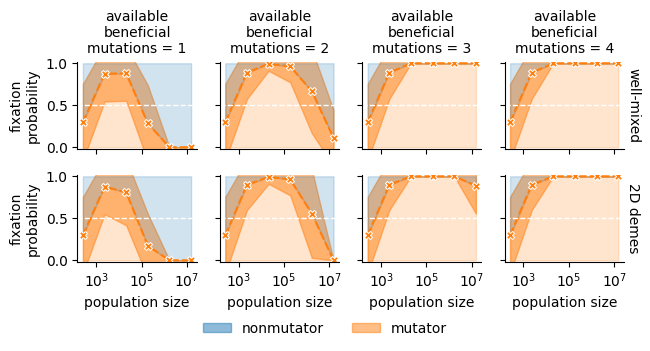

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=se+hue=genotype+row=population-structure+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=se+hue=genotype+row=population-structure+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


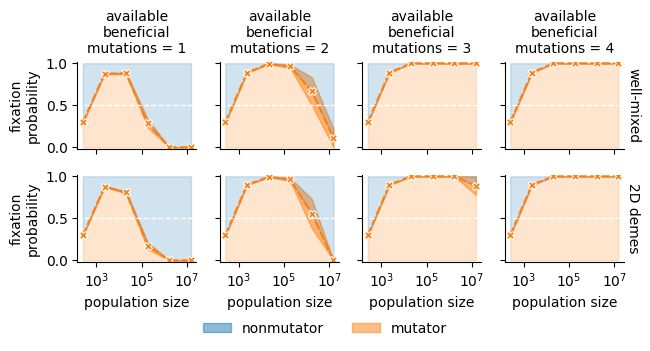

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=ci+hue=genotype+row=population-structure+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=ci+hue=genotype+row=population-structure+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


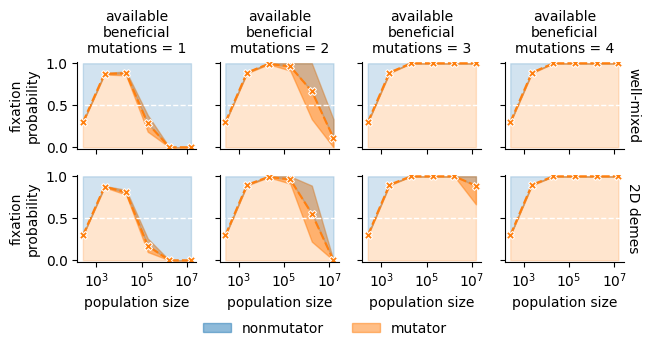

/home/runner/work/hypermutator-dynamics/hypermutator-dynamics/binder/pylib/viz/_size_fixation_areaplot.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  g = sns.relplot(


teeplots/cupy-5050-traits/col=available-beneficial-mutations+hue=genotype+row=population-structure+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-traits/col=available-beneficial-mutations+hue=genotype+row=population-structure+style=genotype+viz=size-fixation-areaplot+x=population-size+y=fixation-probability+ext=.png


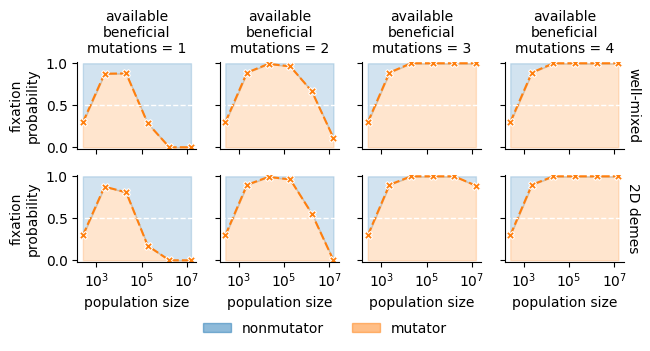

In [8]:
for errorbar in "sd", "se", "ci", None:
    with tp.teed(
        size_fixation_areaplot,
        fixprobs_df=dfxs[
            dfxs["available beneficial mutations"] <= 4
        ],
        x="population size",
        y="fixation probability",
        hue="genotype",
        hue_order=["nonmutator", "mutator"],
        col="available\nbeneficial\nmutations",
        row="population\nstructure",
        style="genotype",
        style_order=["nonmutator", "mutator"],
        errorbar=errorbar,
        height=1.65,
        facet_kws=dict(legend_out=False, margin_titles=True),
        markers=True,
        teeplot_subdir=teeplot_subdir,
    ) as teed:
        # teed.figure.suptitle(f"n={apn} agents per node", x=0.63, y=1.06)
        teed.set_titles(col_template="{col_var} = {col_name:.0f}")
        teed.set_titles(row_template="{row_name}")
        teed.set_ylabels("fixation\nprobability")
        teed.tight_layout()
        sns.move_legend(
            teed,
            "lower center",
            bbox_to_anchor=(0.5, -0.07),
            frameon=False,
            ncol=2,
            title=None,
        )
        for ax in teed.axes.flat:
            ax.set_xticks([1e3, 1e5, 1e7])
        teed.tight_layout()


teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=sd+hue=population-structure+kind=line+palette=dark2+style=population-structure+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=sd+hue=population-structure+kind=line+palette=dark2+style=population-structure+viz=relplot+x=population-size+y=fixation-probability+ext=.png


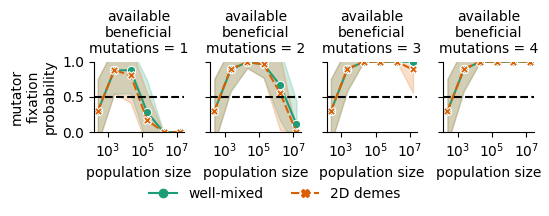

teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=se+hue=population-structure+kind=line+palette=dark2+style=population-structure+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=se+hue=population-structure+kind=line+palette=dark2+style=population-structure+viz=relplot+x=population-size+y=fixation-probability+ext=.png


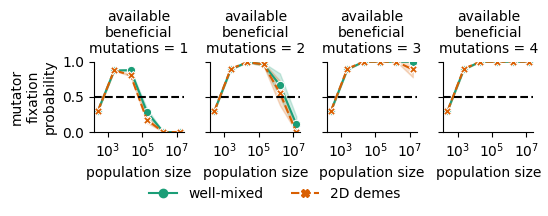

teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=ci+hue=population-structure+kind=line+palette=dark2+style=population-structure+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-traits/col=available-beneficial-mutations+errorbar=ci+hue=population-structure+kind=line+palette=dark2+style=population-structure+viz=relplot+x=population-size+y=fixation-probability+ext=.png


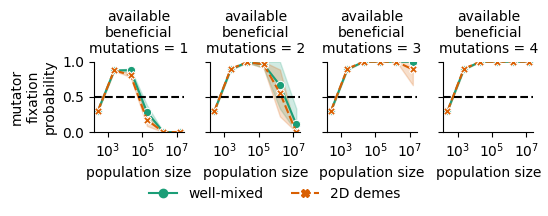

teeplots/cupy-5050-traits/col=available-beneficial-mutations+hue=population-structure+kind=line+palette=dark2+style=population-structure+viz=relplot+x=population-size+y=fixation-probability+ext=.pdf
teeplots/cupy-5050-traits/col=available-beneficial-mutations+hue=population-structure+kind=line+palette=dark2+style=population-structure+viz=relplot+x=population-size+y=fixation-probability+ext=.png


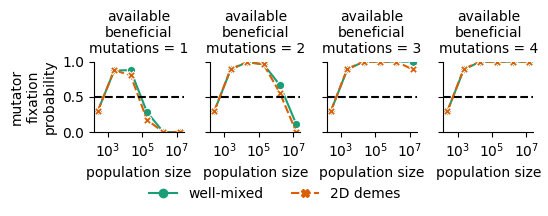

In [9]:
for errorbar in "sd", "se", "ci", None:
    with tp.teed(
        sns.relplot,
        data=dfxs[
            (dfxs["available beneficial mutations"] <= 4)
            & (dfxs["genotype"] == "mutator")
        ],
        x="population size",
        y="fixation probability",
        hue="population\nstructure",
        col="available\nbeneficial\nmutations",
        style="population\nstructure",
        aspect=0.7,
        errorbar=errorbar,
        height=2,
        facet_kws=dict(legend_out=False, margin_titles=True),
        kind="line",
        markers=True,
        palette="Dark2",
        teeplot_subdir=teeplot_subdir,
    ) as teed:
        teed.set(xscale="log")
        teed.set(ylim=(0, 1))
        teed.set_titles(col_template="{col_var} = {col_name:.0f}")
        teed.set_titles(row_template="{row_name}")
        teed.set_ylabels("mutator\nfixation\nprobability")
        teed.tight_layout()
        sns.move_legend(
            teed,
            "lower center",
            bbox_to_anchor=(0.5, -0.09),
            frameon=False,
            ncol=2,
            title=None,
        )
        for ax in teed.axes.flat:
            ax.set_xticks([1e3, 1e5, 1e7])
            ax.axhline(0.5, color="black", linestyle="--")
        teed.tight_layout()


In [10]:
groupby = dfxs[
    (dfxs["available beneficial mutations"] <= 4)
    & (dfxs["genotype"] == "mutator")
].groupby(["available beneficial mutations", "population size"])

results = []
for (beneficial_mut, pop_size), group in groupby:
    (g1, grp1), (g2, grp2) = group.groupby("population\nstructure")
    group_2D = grp1
    group_well_mixed = grp2

    n_g1 = grp1.shape[0]
    n_g2 = grp2.shape[0]

    stat, p_val = scipy_stats.mannwhitneyu(
        grp1["fixation probability"],
        grp2["fixation probability"],
        alternative="two-sided",
    )

    results.append(
        {
            "available beneficial mutations": beneficial_mut,
            "population size": pop_size,
            f"n {g1}": n_g1,
            f"n {g2}": n_g2,
            "U statistic": stat,
            "p-value": p_val,
            "Bonferroni corrected p-value": min(p_val * len(groupby), 1.0),
        }
    )

results_table = pd.DataFrame(results)
results_table


,available beneficial mutations,population size,n 2D demes,n well-mixed,U statistic,p-value,Bonferroni corrected p-value
0,1,256,59049,59049,1.743392e+09,1.000000,1.000000
1,1,2304,6561,6561,2.156273e+07,0.750414,1.000000
2,1,20736,729,729,2.471310e+05,0.000231,0.005542
3,1,186624,81,81,2.916000e+03,0.093565,1.000000
4,1,1679616,9,9,4.050000e+01,1.000000,1.000000
5,1,15116544,9,9,4.050000e+01,1.000000,1.000000
6,2,256,59049,59049,1.743392e+09,1.000000,1.000000
7,2,2304,6561,6561,2.173331e+07,0.069818,1.000000
8,2,20736,729,729,2.657205e+05,1.000000,1.000000
9,2,186624,81,81,3.280500e+03,1.000000,1.000000
